In [51]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [52]:
train_df = pd.read_csv("/content/ratings_train.csv")
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [53]:
train_df, valid_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=42)
print(train_df.shape)
print(valid_df.shape)

(120000, 3)
(30000, 3)


In [54]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

In [56]:
csv_file_path = '/content/ratings_train.csv'  # 여기에 실제 파일 경로를 입력하세요

# CSV 파일 읽기
df = pd.read_csv(csv_file_path)
print(df.shape)

(150000, 3)


In [57]:
df.drop_duplicates(subset=['document'], inplace=True)
df.shape
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(df.isnull().values.any())

# 'text' 열은 댓글 텍스트를, 'label' 열은 라벨 정보를 담고 있어야 합니다.
texts = df['document'].tolist()
labels = df['label'].tolist()

False


In [58]:
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
labels = torch.tensor(labels)

In [59]:
print(type(inputs))
print(type(labels))

<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'torch.Tensor'>


In [66]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name).to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
# 데이터셋 및 데이터로더 준비
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 옵티마이저와 로스 함수 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
import torch

# 모델과 옵티마이저를 cuda 디바이스로 옮기기
model.to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(dataloader):
        input_ids, attention_mask, target_labels = batch

        # 데이터를 cuda 디바이스로 옮기기
        input_ids = input_ids.to('cuda')
        attention_mask = attention_mask.to('cuda')
        target_labels = target_labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)[0]
        loss = loss_fn(outputs, target_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


  0%|          | 0/4569 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.5543


  0%|          | 0/4569 [00:00<?, ?it/s]

In [6]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 48.9 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [22]:
train_df['document'].nunique(), train_df['label'].nunique()

(117176, 2)

In [23]:
train_df.drop_duplicates(subset=['document'], inplace=True)

<Axes: >

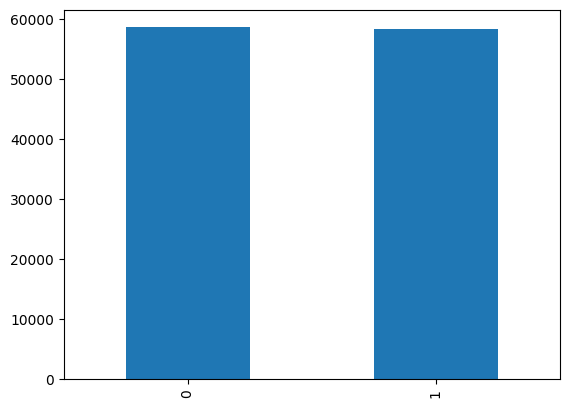

In [24]:
train_df['label'].value_counts().plot(kind = 'bar')

In [25]:
print(train_df.isnull().values.any())
print(valid_df.isnull().values.any())

True
True


In [26]:
train_df.loc[train_df.document.isnull()]
valid_df.loc[valid_df.document.isnull()]

,id,document,label
25857,2172111,NaN,1
140721,1034283,NaN,0


In [27]:
train_df = train_df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_df.isnull().values.any())

False


In [28]:
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head()

<ipython-input-28-c741bf8267bf>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
104025,7757635,나의 티모를 더럽히지마,0
5415,9554776,배비장전을 독특하게 각색한 의외로 재미있게 본 영화 배우들의 연기력과 사극톤이 부족...,1
75612,9623284,아기와의 교감도 없어 보이는 미혼모란 탈을 쓴 여자주인공의 행태가 문제인 드라마 아...,0
138169,10162069,아무 생각없이 평점 안보고 영화를 보다가 마지막 엔딩에서 소름 돋는걸 느끼는 내모습...,1
87184,8472187,혼자서 다 할거면 제자는 왜 키우는가,0


In [29]:
train_df = train_df.dropna(how = 'any')
print(len(train_df))

117176


In [ ]:
valid_df.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
valid_df['document'] = valid_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
valid_df['document'] = valid_df['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
valid_df['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
valid_df = valid_df.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(valid_df))

전처리 후 테스트용 샘플의 개수 : 29352


<ipython-input-26-e9981bde0a87>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  valid_df['document'] = valid_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-26-e9981bde0a87>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  valid_df['document'] = valid_df['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
X_train = []
for sentence in tqdm(train_df['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 117176/117176 [09:50<00:00, 198.42it/s]


In [ ]:
X_test = []
for sentence in tqdm(valid_df['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 29352/29352 [02:38<00:00, 185.57it/s]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 39778
등장 빈도가 2번 이하인 희귀 단어의 수: 22385
단어 집합에서 희귀 단어의 비율: 56.2748252803057
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1583711892137694


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17394


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_df['label'])
y_test = np.array(valid_df['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

116322
116322


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.765203486872647


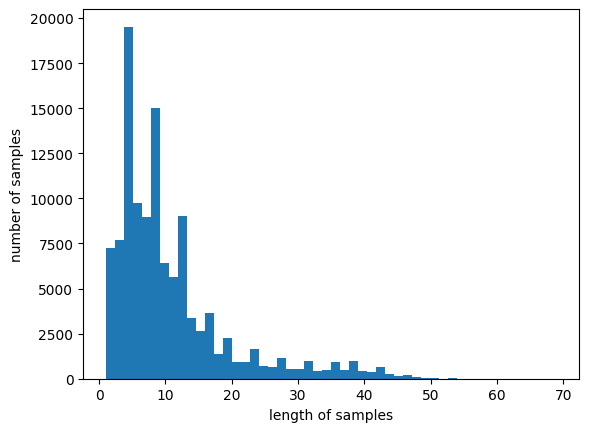

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.37165798387235


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
1455/1455 [==============================] - ETA: 0s - loss: 0.4186 - acc: 0.8060
Epoch 1: val_acc improved from -inf to 0.82609, saving model to best_model.h5
1455/1455 [==============================] - 42s 26ms/step - loss: 0.4186 - acc: 0.8060 - val_loss: 0.3872 - val_acc: 0.8261
Epoch 2/15
1455/1455 [==============================] - ETA: 0s - loss: 0.3510 - acc: 0.8479
Epoch 2: val_acc improved from 0.82609 to 0.84066, saving model to best_model.h5
1455/1455 [==============================] - 17s 11ms/step - loss: 0.3510 - acc: 0.8479 - val_loss: 0.3579 - val_acc: 0.8407
Epoch 3/15
1455/1455 [==============================] - ETA: 0s - loss: 0.3273 - acc: 0.8608
Epoch 3: val_acc improved from 0.84066 to 0.84754, saving model to best_model.h5
1455/1455 [==============================] - 12s 8ms/step - loss: 0.3273 - acc: 0.8608 - val_loss: 0.3508 - val_acc: 0.8475
Epoch 4/15
1455/1455 [==============================] - ETA: 0s - loss: 0.3068 - acc: 0.8710
Epoch 4: val_a

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

918/918 [==============================] - 4s 4ms/step - loss: 0.3632 - acc: 0.8487

 테스트 정확도: 0.8487


In [ ]:
def load_model_fn():
  model_path = './best_model.h5'

  from tensorflow.keras.layers import Embedding, Dense, LSTM
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.models import load_model
  from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

  embedding_dim = 100
  hidden_units = 128

  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(LSTM(hidden_units))
  model.add(Dense(1, activation='sigmoid'))

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

  loaded_model = load_model(model_path)
  return loaded_model

In [ ]:
def infer(x_test, model):
  result = []
  for new_sentence in x_test:
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
      print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
      result.append(1)
    else:
      print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
      result.append(0)

  return result

In [ ]:
result = infer(['감독 뭐하는 놈이냐?', '와 개쩐다 정말 세계관 최강자들의 영화다'], load_model_fn())

1/1 [==============================] - 0s 385ms/step
99.20% 확률로 부정 리뷰입니다.

1/1 [==============================] - 0s 21ms/step
89.46% 확률로 긍정 리뷰입니다.



In [ ]:
result

[0, 1]